In [59]:
import pandas as pd
import numpy as np
import random as rd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [73]:
grades = pd.read_csv('../EPM_dataset/Data/Seyoung/grades.csv',index_col = 0)

In [83]:
for i in range(2,7):
    #grades['FIN'] = grades.iloc[:,6:10].sum(axis = 1)
    grades[f'MID{i}_Rank'] = grades[f'MID{i}'].rank(pct= True)
    grades[f'MID{i}_Hierachy'] = 0
    grades.loc [grades[f'MID{i}_Rank'] > 0.66,f'MID{i}_Hierachy'] = 0
    grades.loc[(grades[f'MID{i}_Rank']<= 0.66 ) & (grades[f'MID{i}_Rank'] > 0.33 ) ,f'MID{i}_Hierachy'] = 1
    grades.loc[grades[f'MID{i}_Rank'] <= 0.33,f'MID{i}_Hierachy'] = 2

grades['FIN'] = grades.iloc[:,6:10].sum(axis = 1)
grades['FIN_Rank'] = grades['FIN'].rank(pct = True)
grades['FIN_Hierachy'] = 0
grades.loc [grades['FIN_Rank'] > 0.66,'FIN_Hierachy'] = 0
grades.loc[(grades['FIN_Rank']<= 0.66 ) & (grades['FIN_Rank'] > 0.33 ) ,'FIN_Hierachy'] = 1
grades.loc[grades['FIN_Rank'] <= 0.33,'FIN_Hierachy'] = 2


In [84]:
grades.iloc[:,-10:]

,MID3_Hierachy,MID4_Rank,MID4_Hierachy,MID5_Rank,MID5_Hierachy,MID6_Rank,MID6_Hierachy,FIN,FIN_Rank,FIN_Hierachy
0,2,0.467742,1,0.709677,0,0.526882,1,135.0,0.731183,0
1,0,0.467742,1,0.709677,0,0.204301,2,85.0,0.311828,2
2,0,0.467742,1,0.709677,0,0.069892,2,159.0,0.903226,0
3,0,0.833333,0,0.295699,2,0.688172,0,36.5,0.129032,2
4,0,0.833333,0,0.709677,0,0.688172,0,100.5,0.462366,1
...,...,...,...,...,...,...,...,...,...,...
88,2,0.026882,2,0.295699,2,0.069892,2,68.5,0.284946,2
89,0,0.166667,2,0.295699,2,0.419355,1,88.0,0.333333,1
90,2,0.026882,2,0.295699,2,0.069892,2,69.0,0.301075,2
91,2,0.467742,1,0.709677,0,0.688172,0,149.0,0.822581,0


In [53]:
# load data
var_list = []
for i in range(2,7):
    path = '../EPM_dataset/Data/Seyoung/scaled_variables_session_' + str(i) + '.csv'
    var = pd.read_csv(path)
    var_list.append(var)

# verify
var_list[0].head()

,ID,DUR_Aulaweb,DUR_Blank,DUR_Deeds,DUR_Diagram,DUR_Other,DUR_Properties,DUR_Study,DUR_TextEditor,KS_Aulaweb,KS_Blank,KS_Deeds,KS_Diagram
0,1,-0.180077,-0.223501,-0.731890,1.869931,-0.321309,-0.187415,-0.021704,-0.748815,-0.225401,-0.409872,-0.359030,-0.365649
1,2,-0.179064,-0.222049,0.070617,-0.176423,-0.286618,7.977765,-0.568710,0.277439,-0.225401,-0.409872,-0.163113,-0.365649
2,3,-0.179587,-0.002275,-0.522372,-0.207838,0.010717,-0.282903,0.089327,0.620493,-0.225401,-0.409872,-0.268846,-0.365649
3,4,-0.177029,-0.161910,-0.104139,-0.345523,-0.009766,-0.252656,-0.647769,-0.400458,0.439615,-0.409872,-0.038721,1.171952
4,5,-0.179424,-0.223941,-0.424156,-0.321302,-0.320411,-0.018654,-0.354565,-0.046255,-0.225401,0.608598,3.083515,-0.365649


In [77]:
# Scaler
scaled_var_list = []
for var in var_list:
    # I'm selecting only numericals to scale
    numerical = var.select_dtypes(include='float64').columns
    # This will transform the selected columns and merge to the original data frame
    var.loc[:,numerical] = StandardScaler().fit_transform(var.loc[:,numerical])
    scaled_var_list.append(var)
    
# verify
len(scaled_var_list)

5

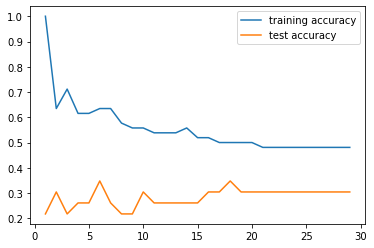

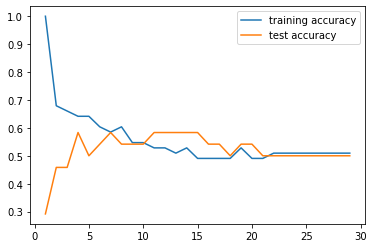

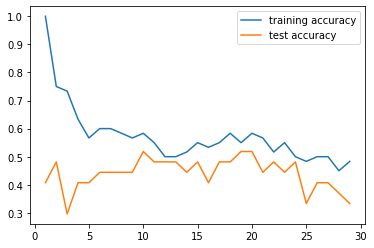

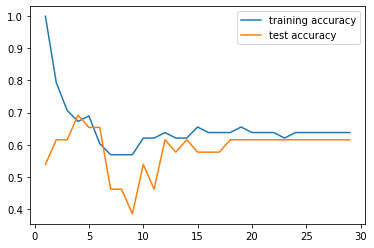

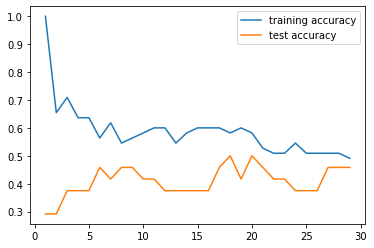

In [79]:
# KNN with all variables

for i in range(5):
    data_new = pd.merge(var_list[i], grades[['ID',f'MID{i+2}_Hierachy']], how='inner', on=['ID'])
    x = data_new.drop(columns = ['ID',f'MID{i+2}_Hierachy'])
    y = data_new[f'MID{i+2}_Hierachy']
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)
    training_accuracy = []
    test_accuracy = []
    #Train the model and make predictions
    model = KNeighborsClassifier(n_neighbors = 10)
    model.fit(x_training_data, y_training_data)
    predictions = model.predict(x_test_data)
    #print(classification_report(y_test_data, predictions))
    #print(confusion_matrix(y_test_data, predictions))
    error_rates = []
    n_settings = range(1,30)
    for i in n_settings:
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(x_training_data,y_training_data)
        training_accuracy.append(knn.score(x_training_data,y_training_data))
        test_accuracy.append(knn.score(x_test_data,y_test_data))
    plt.plot(n_settings,training_accuracy,label = "training accuracy")
    plt.plot(n_settings,test_accuracy,label = "test accuracy")
    plt.legend()
    plt.show()
    


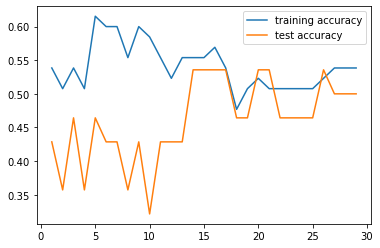

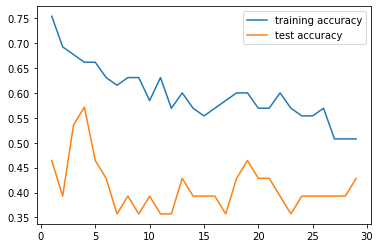

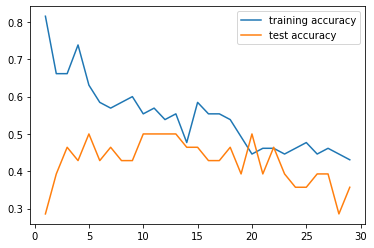

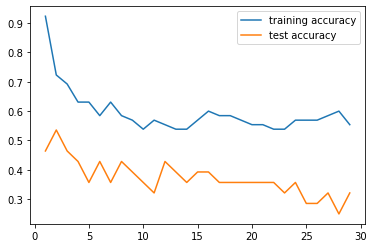

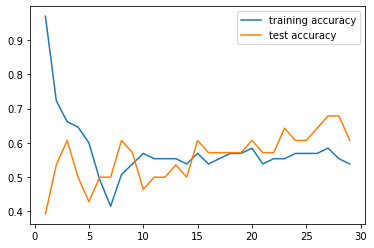

In [99]:
# KNN with grades

for i in range(5):
    x = grades[[f'MID{n+2}' for n in range(i+1)]]
    y = grades['FIN_Hierachy']
    x = StandardScaler().fit_transform(x)
    x_training_data, x_test_data, y_training_data, y_test_data = train_test_split(x, y, test_size = 0.3)
    training_accuracy = []
    test_accuracy = []
    #Train the model and make predictions
    model = KNeighborsClassifier(n_neighbors = 10)
    model.fit(x_training_data, y_training_data)
    predictions = model.predict(x_test_data)
    #print(classification_report(y_test_data, predictions))
    #print(confusion_matrix(y_test_data, predictions))
    error_rates = []
    n_settings = range(1,30)
    for i in n_settings:
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(x_training_data,y_training_data)
        training_accuracy.append(knn.score(x_training_data,y_training_data))
        test_accuracy.append(knn.score(x_test_data,y_test_data))
    plt.plot(n_settings,training_accuracy,label = "training accuracy")
    plt.plot(n_settings,test_accuracy,label = "test accuracy")
    plt.legend()
    plt.show()
    


In [55]:
#Selecting an optimal K value
    error_rates = []
    for i in np.arange(1, 101):
        new_model = KNeighborsClassifier(n_neighbors = i)
        new_model.fit(x_training_data, y_training_data)
        new_predictions = new_model.predict(x_test_data)
        error_rates.append(np.mean(new_predictions != y_test_data))

    plt.figure(figsize=(16,12))

    plt.plot(error_rates)

In [105]:
data_new

,ID,DUR_Aulaweb,DUR_Blank,DUR_Deeds,DUR_Diagram,DUR_Other,DUR_Properties,DUR_Study,DUR_TextEditor,KS_Aulaweb,KS_Blank,KS_Deeds,KS_Diagram,MID2_Hierachy
0,1,-0.180077,-0.223501,-0.731890,1.869931,-0.321309,-0.187415,-0.021704,-0.748815,-0.225401,-0.409872,-0.359030,-0.365649,0
1,2,-0.179064,-0.222049,0.070617,-0.176423,-0.286618,7.977765,-0.568710,0.277439,-0.225401,-0.409872,-0.163113,-0.365649,1
2,3,-0.179587,-0.002275,-0.522372,-0.207838,0.010717,-0.282903,0.089327,0.620493,-0.225401,-0.409872,-0.268846,-0.365649,1
3,4,-0.177029,-0.161910,-0.104139,-0.345523,-0.009766,-0.252656,-0.647769,-0.400458,0.439615,-0.409872,-0.038721,1.171952,0
4,5,-0.179424,-0.223941,-0.424156,-0.321302,-0.320411,-0.018654,-0.354565,-0.046255,-0.225401,0.608598,3.083515,-0.365649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,100,-0.143273,0.021325,-0.480431,0.089639,-0.148921,2.125473,-0.342516,-0.724239,6.241309,-0.183545,0.147867,-0.365649,1
71,101,-0.150673,-0.220802,-0.749819,-0.410013,-0.140200,-0.284588,-0.586811,-0.386493,-0.225401,-0.409872,-0.853488,-0.365649,0
72,102,-0.179400,-0.221470,-0.634870,-0.401461,-0.303834,-0.285515,-0.408132,-0.519668,-0.225401,-0.409872,-0.415006,-0.365649,0
73,103,-0.176630,-0.224005,-0.398235,0.414184,-0.303077,0.620722,0.361131,1.119425,-0.225401,-0.409872,0.290918,6.435277,2


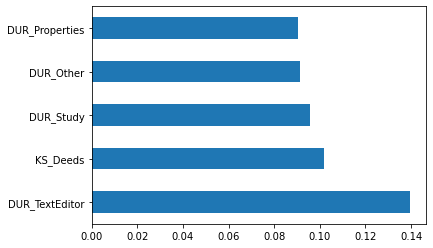

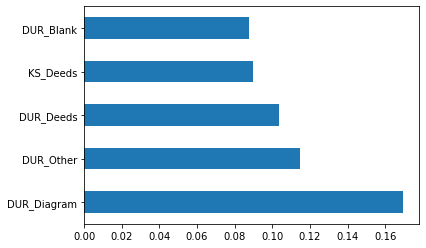

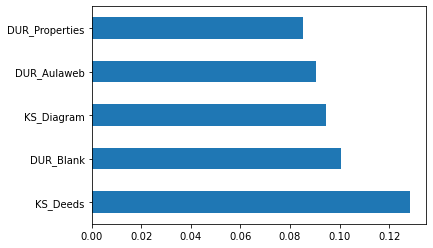

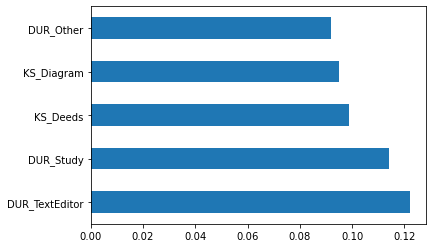

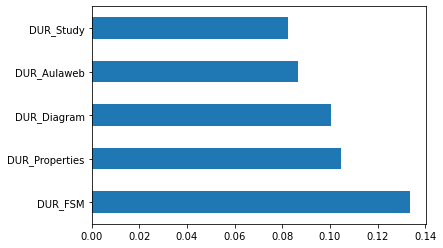

In [117]:
# Feature Selection
# Tree-based feature selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=50)

for i in range(5):
    data = pd.merge(scaled_var_list[i], grades[['ID',f'MID{i+2}_Hierachy']], how='inner', on=['ID'])
    X = data.drop(columns = ['ID',f'MID{i+2}_Hierachy'])
    y = data[f'MID{i+2}_Hierachy']
    clf = clf.fit(X, y)
    #plot graph of feature importances for better visualization
    feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
    feat_importances.nlargest(5).plot(kind='barh')
    plt.show()
    

In [116]:
var_list[0]

,ID,DUR_Aulaweb,DUR_Blank,DUR_Deeds,DUR_Diagram,DUR_Other,DUR_Properties,DUR_Study,DUR_TextEditor,KS_Aulaweb,KS_Blank,KS_Deeds,KS_Diagram
0,1,-0.180077,-0.223501,-0.731890,1.869931,-0.321309,-0.187415,-0.021704,-0.748815,-0.225401,-0.409872,-0.359030,-0.365649
1,2,-0.179064,-0.222049,0.070617,-0.176423,-0.286618,7.977765,-0.568710,0.277439,-0.225401,-0.409872,-0.163113,-0.365649
2,3,-0.179587,-0.002275,-0.522372,-0.207838,0.010717,-0.282903,0.089327,0.620493,-0.225401,-0.409872,-0.268846,-0.365649
3,4,-0.177029,-0.161910,-0.104139,-0.345523,-0.009766,-0.252656,-0.647769,-0.400458,0.439615,-0.409872,-0.038721,1.171952
4,5,-0.179424,-0.223941,-0.424156,-0.321302,-0.320411,-0.018654,-0.354565,-0.046255,-0.225401,0.608598,3.083515,-0.365649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,101,-0.150673,-0.220802,-0.749819,-0.410013,-0.140200,-0.284588,-0.586811,-0.386493,-0.225401,-0.409872,-0.853488,-0.365649
78,102,-0.179400,-0.221470,-0.634870,-0.401461,-0.303834,-0.285515,-0.408132,-0.519668,-0.225401,-0.409872,-0.415006,-0.365649
79,103,-0.176630,-0.224005,-0.398235,0.414184,-0.303077,0.620722,0.361131,1.119425,-0.225401,-0.409872,0.290918,6.435277
80,104,-0.155397,-0.216145,0.127902,-0.050916,-0.302861,-0.179523,0.793276,-0.373707,-0.225401,0.155945,2.974673,2.886968


In [101]:
scaled_var_list[0]

,ID,DUR_Aulaweb,DUR_Blank,DUR_Deeds,DUR_Diagram,DUR_Other,DUR_Properties,DUR_Study,DUR_TextEditor,KS_Aulaweb,KS_Blank,KS_Deeds,KS_Diagram
0,1,-0.180077,-0.223501,-0.731890,1.869931,-0.321309,-0.187415,-0.021704,-0.748815,-0.225401,-0.409872,-0.359030,-0.365649
1,2,-0.179064,-0.222049,0.070617,-0.176423,-0.286618,7.977765,-0.568710,0.277439,-0.225401,-0.409872,-0.163113,-0.365649
2,3,-0.179587,-0.002275,-0.522372,-0.207838,0.010717,-0.282903,0.089327,0.620493,-0.225401,-0.409872,-0.268846,-0.365649
3,4,-0.177029,-0.161910,-0.104139,-0.345523,-0.009766,-0.252656,-0.647769,-0.400458,0.439615,-0.409872,-0.038721,1.171952
4,5,-0.179424,-0.223941,-0.424156,-0.321302,-0.320411,-0.018654,-0.354565,-0.046255,-0.225401,0.608598,3.083515,-0.365649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,101,-0.150673,-0.220802,-0.749819,-0.410013,-0.140200,-0.284588,-0.586811,-0.386493,-0.225401,-0.409872,-0.853488,-0.365649
78,102,-0.179400,-0.221470,-0.634870,-0.401461,-0.303834,-0.285515,-0.408132,-0.519668,-0.225401,-0.409872,-0.415006,-0.365649
79,103,-0.176630,-0.224005,-0.398235,0.414184,-0.303077,0.620722,0.361131,1.119425,-0.225401,-0.409872,0.290918,6.435277
80,104,-0.155397,-0.216145,0.127902,-0.050916,-0.302861,-0.179523,0.793276,-0.373707,-0.225401,0.155945,2.974673,2.886968


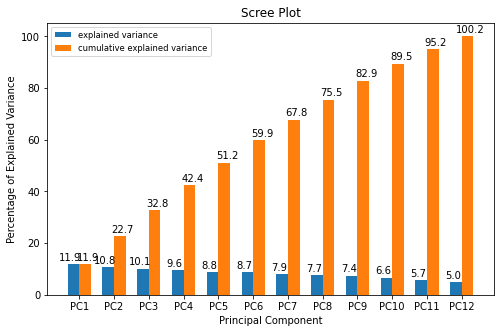

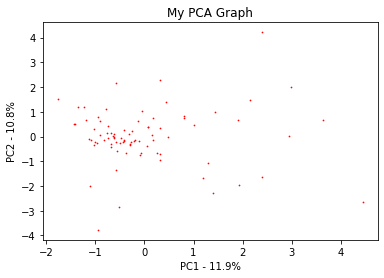

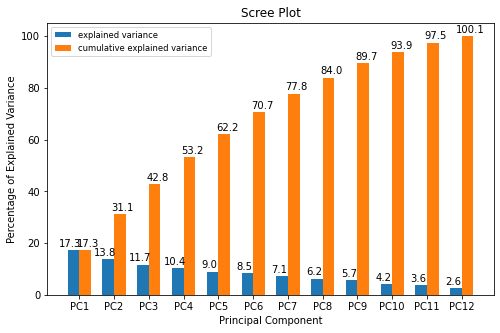

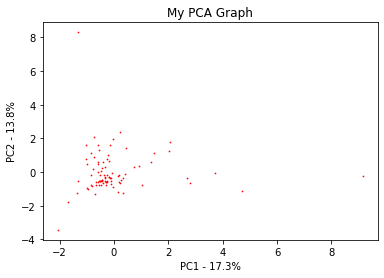

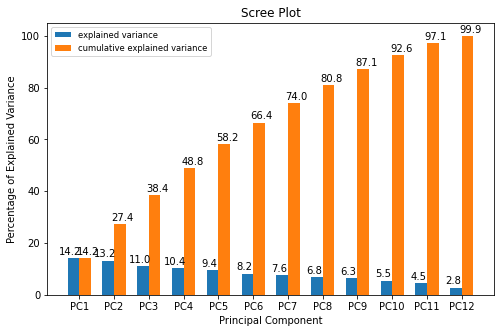

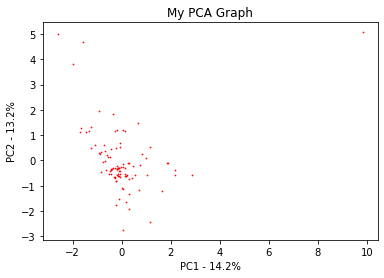

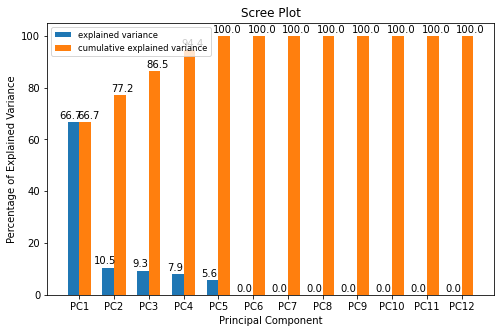

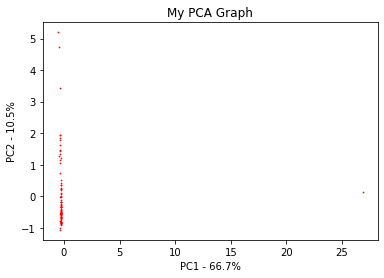

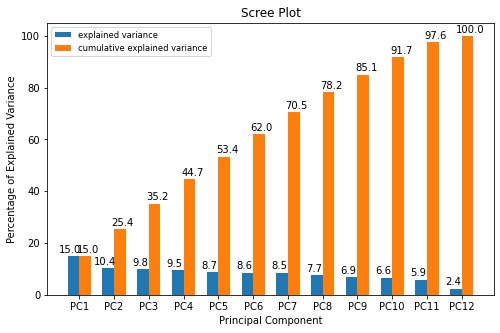

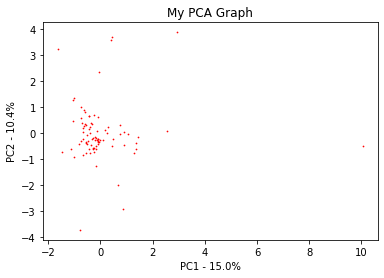

In [34]:
#PCA
%matplotlib inline
for i in range(5):
    dataforpca = scaled_var_list[i].drop(columns = 'ID')
    pca = PCA() # create a PCA object
    pca.fit(dataforpca) # do the math
    pca_data = pca.transform(dataforpca) # get PCA coordinates for scaled_data
    # Draw a scree plot and a PCA plot #
    #The following code constructs the Scree plot
    per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
    acc_var = np.round(np.cumsum(per_var),decimals =1 )# the accumulated variance
    # acc_var = [100.0 if var>100 else var for var in acc_var ]
    labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
    plt.figure(figsize = (8,5))
    bar1 = plt.bar(x = (np.arange(1,len(per_var)+1)*3-0.5), height=per_var, width = 1,label = 'explained variance')
    bar2 = plt.bar(x = (np.arange(1,len(per_var)+1)*3+0.5), height=acc_var, width = 1,label = 'cumulative explained variance')
    plt.gca().set_xticks(np.arange(1,len(per_var)+1)*3)
    plt.gca().set_xticklabels(labels)

    for idx,rect in enumerate(bar1):
        height =per_var[idx]
        plt.gca().annotate(height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(-3, 1.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    for idx,rect in enumerate(bar2):
        height = acc_var[idx]
        plt.gca().annotate(height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(3, 1.5),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.ylabel('Percentage of Explained Variance')
    plt.xlabel('Principal Component')
    plt.title('Scree Plot')
    plt.legend(loc= 'best',fontsize='small') 
    #plt.savefig('scree_plot.jpg',dpi=200)
    plt.show()

    #the following code makes a fancy looking plot using PC1 and PC2
    pca_df = pd.DataFrame(pca_data, index=dataforpca.index.values, columns=labels)

    plt.scatter(pca_df.PC1, pca_df.PC2,c='r', s = 0.5)
    plt.title('My PCA Graph')
    plt.xlabel('PC1 - {0}%'.format(per_var[0]))
    plt.ylabel('PC2 - {0}%'.format(per_var[1]))

    # plt.savefig('PCA distribution.jpg',dpi=200)
    plt.show()

    # Determine which attributes had the biggest influence on PC1
    ## get the name of the top 10 measurements (genes) that contribute
    ## most to pc1.
    ## first, get the loading scores

#     loading_scores1 = pd.DataFrame(columns=dataforpca.columns) 
#     for i in range(5):
#         loading_scores1=loading_scores1.append(pd.DataFrame(pca.components_[i].reshape(1,-1),columns=dataforpca.columns,index=['PC'+str(i+1)]))

#     loading_scores1.loc['Total',:]=loading_scores1.abs().sum(axis = 0)
#     # print(loading_scores.loc['Total',:].sort_values(ascending=False)[:10])
#     loading_scores1.loc['weighted_total',:] = 0
#     for i in range(5):
#         loading_scores1.loc['weighted_total',:]=loading_scores1.loc['weighted_total',:]+loading_scores1.abs().iloc[i] *per_var[i]/100
#     top_features1 = loading_scores1.loc['weighted_total',:].sort_values(ascending=False).index.values

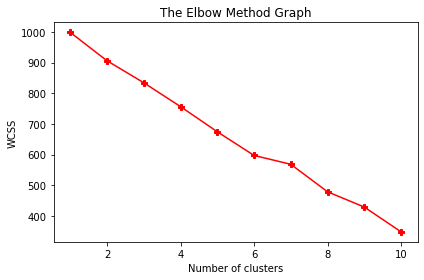

DBS: 35
Silhouette Score: 7


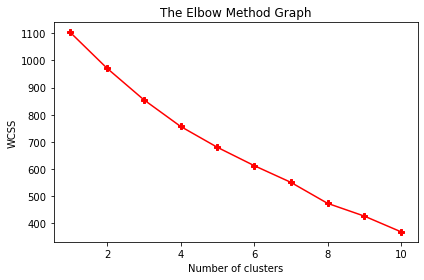

DBS: 35
Silhouette Score: 2


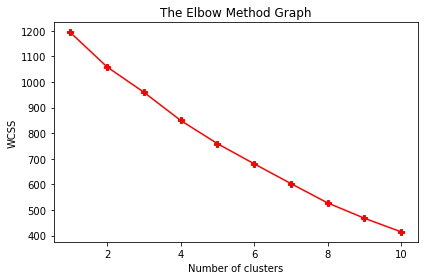

DBS: 35
Silhouette Score: 4


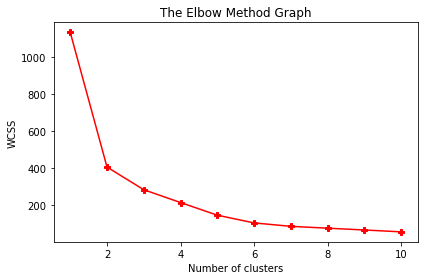

DBS: 35
Silhouette Score: 2


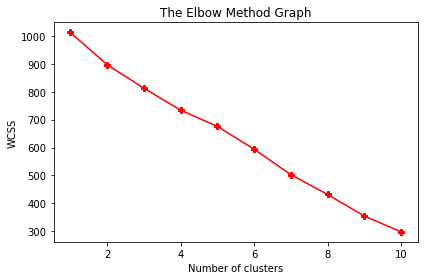

DBS: 35
Silhouette Score: 2


In [42]:
#画出手肘图，判断聚类个数
#interest_features = ['velocity_max', 'velocity_mean', 'Longacc_mean']
#feature_index = np.where(filtered.columns.isin(interest_features))[0]
for i in range(5):
    data_new =  scaled_var_list[i].drop(columns = 'ID')

    wcss=[]
    for clu_n in range(1,11): 
        kmeans = KMeans(n_clusters=clu_n, init ='k-means++', max_iter=300,  n_init=10,random_state=0 )
        kmeans.fit(data_new)
        #kmeans algorithm fits to the X dataset
        wcss.append(kmeans.inertia_)

    #kmeans inertia_ attribute is:  Sum of squared distances of samples #to their closest cluster center.
    #4.Plot the elbow graph
    plt.plot(range(1,11),wcss,'rP-')
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.tight_layout()
    #plt.savefig('elbow.jpg',dpi=300)
    plt.show()

    # 设定最终希望得到的类数量

    for clu_n in k:
        clf_KMeans=KMeans(n_clusters=clu_n,random_state=4)
        clf_KMeans.fit(data_new)
        labels=clf_KMeans.labels_
        score=davies_bouldin_score(data_new, labels)
        scores.append(score) #计算每次聚类的得分
    cluster_num =np.argmin(scores)+2
    print("DBS:",cluster_num)
    si_scores = []
    k=range(2,10)
    for clu_n in k:
        clf_KMeans=KMeans(n_clusters=clu_n,random_state=4)
        clf_KMeans.fit(data_new)
        labels=clf_KMeans.labels_
        si_score=silhouette_score(data_new, labels)
        si_scores.append(si_score)
    cluster_num =np.argmax(si_scores)+2
    print("Silhouette Score:",cluster_num)
    clf = KMeans(n_clusters=4,n_init=15, tol = 0 ,random_state=4)# , verbose=1)#用不同的初始化质心运行算法的次数，这个值一般对于k较大时候适用，默认是10
    y_pred=clf.fit_predict(data_new)
    scaled_var_list[i]['Cluster_Label'] = y_pred

In [47]:
for i in range(5):
    print(scaled_var_list[i].loc[scaled_var_list[i].Cluster_Label == 3,'ID'].shape[0])

2
4
2
3
1


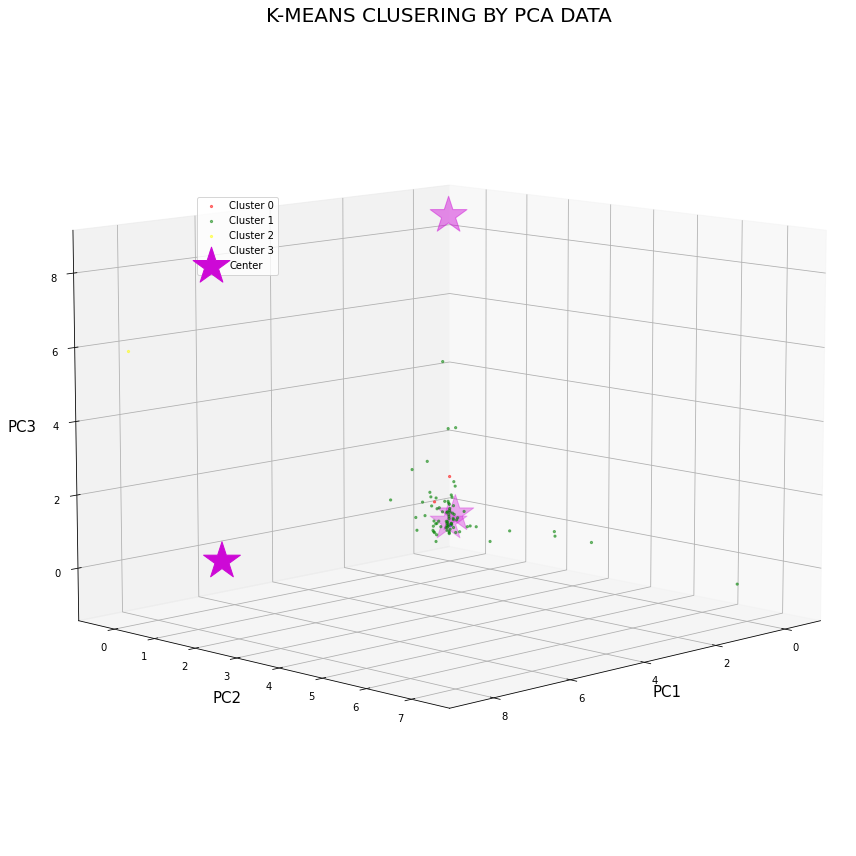

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D#额外添加一个模块，即 Axes 3D 3D 坐标轴显示

plt.rcParams['font.sans-serif'] = 'SimHei'#中文顺利输出
plt.rcParams['axes.unicode_minus']=False #负值输出
fig = plt.figure(figsize=(14,12))
plt.style.use('default')
ax = fig.add_subplot(111, projection='3d')#为了设置s
colors = ['red','green','yellow','blue','magenta','cyan']

for i in range(4):
    #得到 label为i的索引值
    need_idx = np.where(y_pred==i)[0]
    #画出 label为i三个主成分
    #画出只按照三个指标聚类的版本 
    ax.scatter(data_new.iloc[need_idx,2],data_new.iloc[need_idx,3],data_new.iloc[need_idx,4],c=colors[i],alpha=0.5,marker='o',s=5,label="Cluster {}".format(i))

#画出三个指标的center
ax.scatter(clf.cluster_centers_[:,0],clf.cluster_centers_[:,1],clf.cluster_centers_[:,2],c='#CD09D6',marker='*',s=1500,label='Center')

ax.set_title('K-MEANS CLUSERING BY PCA DATA',fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(0.2, 0, 0.6, 0.8))

ax.set_xlabel('PC1',fontsize=15)
ax.set_ylabel('PC2',fontsize=15,labelpad=10)
ax.set_zlabel('PC3',fontsize=15,labelpad=10)
ax.view_init(10,45)
plt.tight_layout()
# plt.savefig(r'kmeans.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# reduce dimensionality
dim_label_list = []
dim_list = []
for scaled_var in scaled_var_list:
    scaled_var = scaled_var.drop(columns=['ID'])
    pca = PCA(n_components=12)
    pca.fit(scaled_var) # calculate loading scores and the variation
    pca_data = pca.transform(scaled_var) # generate coordinates
    #print(pca.feature_names_in_)
    #print(pca.components_)
    per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
    print(per_var)
    dim_label_list.append(pca.feature_names_in_[:12])
    print("\n")
    

In [ ]:
pca.feature_names_in_

In [ ]:
dim_label_list

In [ ]:
# test
labels = list(dim_label_list[0])
labels = ['ID'] + labels
scaled_var_list[0][labels]

In [ ]:
for i, var in enumerate(scaled_var_list):
    labels = list(dim_label_list[i])
    labels = ['ID'] + labels
    session = var[labels]
    file_name = "K_Means_Clustering_Session" + str(i+2) + ".csv"
    session.to_csv('../EPM_dataset/Data/Yinsheng/' + file_name, index=False)